In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

In [2]:
directory = os.path.join(root_directory,'fly_5','func_0')
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 62.71 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.45 sec


In [3]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3 # 0.0045m, or 4.5mm
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        # radians/frame -> m/frame -> m/sec -> mm/sec
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [4]:
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictrac = {}
for behavior in ['Y', 'Z']:
    fictrac[behavior] = interp_fictrac(fictrac_raw, behavior, fps, resolution, expt_len, timestamps, 'xnew')

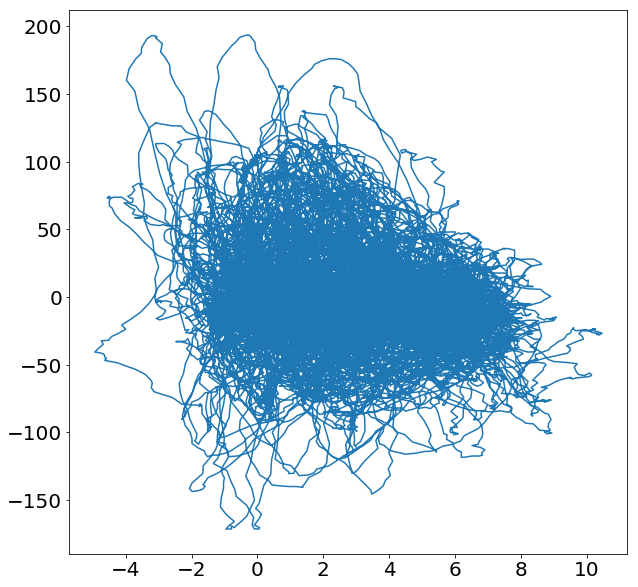

In [5]:
plt.figure(figsize=(10,10))
x=fictrac['Y']
y=fictrac['Z']
plt.plot(x,y)
#plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1)
#plt.ylim(-.15,.15)
#plt.xlim(-.03,.05)

In [6]:
cap = cv2.VideoCapture('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/imports/fictrac/fictrac-20181213_174308-raw.avi')
i=0
frames = []
ret = True
while ret is True and i<90000:
    i+=1
    if i%1000 == 0:
        print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000


In [7]:
#os.mkdir(os.path.join(directory, '20200513_behavior_movie'))
save_path = os.path.join(directory, '20200513_behavior_movie', 'jpeg')
#os.mkdir(save_path)

In [ ]:
log_file = os.path.join(save_path, 'log.txt')


In [ ]:
num_frames = 90000

fig = plt.figure(figsize=(10,10))

for i in range(num_frames):
    t0 = time.time()
    ax_behavior = fig.add_axes([0, 0, 1, 1])
    ax_fly = fig.add_axes([.7, .7, .3, .3])
    ax_fly.axis('off')
    ax_behavior.set_ylim(-200,200)
    ax_behavior.set_xlim(-5,10)
    ax_behavior.set_ylabel('Rotational Velocity (deg/sec)')
    ax_behavior.set_xlabel('Forward Velocity (mm/sec)')
    ax_behavior.set_title('Frame: {}'.format(i))
    ax_behavior.plot(fictrac['Y'], fictrac['Z'], color='k')
    ax_behavior.axvline(0,linestyle='--',color='r')
    ax_behavior.axhline(0,linestyle='--',color='r')
    ax_fly.imshow(frames[i][25:220,315:510,:])
    
    for j in range(50):
        alpha=(1/(j+1))*10
        alpha=min(alpha,1)
        index = i-j
        if index >= 0:
            ax_behavior.plot(fictrac['Y'][index], fictrac['Z'][index], color='r',marker='o',markersize=10,alpha=alpha)
            
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    fig.clf()
    print('frame {}, {}'.format(i, time.time()-t0))

frame 0, 1.0158381462097168
frame 1, 1.22859787940979
frame 2, 1.0408804416656494
frame 3, 1.047922134399414
frame 4, 1.0440027713775635
frame 5, 1.044100284576416
frame 6, 1.0914089679718018
frame 7, 1.0284926891326904
frame 8, 1.0372827053070068
frame 9, 1.0372004508972168
frame 10, 1.0356922149658203
frame 11, 1.0784785747528076
frame 12, 1.3005623817443848
frame 13, 1.0487260818481445
frame 14, 1.0582120418548584
frame 15, 1.0909006595611572
frame 16, 1.1476702690124512
frame 17, 1.1068015098571777
frame 18, 1.1240596771240234
frame 19, 1.0705084800720215
frame 20, 1.055114507675171
frame 21, 1.0540671348571777
frame 22, 1.0485312938690186
frame 23, 1.0531401634216309
frame 24, 1.0849895477294922
frame 25, 1.1451692581176758
frame 26, 1.1865513324737549
frame 27, 1.0595011711120605
frame 28, 1.0889480113983154
frame 29, 1.1038568019866943
frame 30, 1.0782873630523682
frame 31, 1.0733425617218018
frame 32, 1.0827598571777344
frame 33, 1.0846002101898193
frame 34, 1.082902193069458
f

frame 280, 1.1326839923858643
frame 281, 1.286325454711914
frame 282, 1.1211378574371338
frame 283, 1.1273057460784912
frame 284, 1.124621868133545
frame 285, 1.1243681907653809
frame 286, 1.1241905689239502
frame 287, 1.1387219429016113
frame 288, 1.1274819374084473
frame 289, 1.1420793533325195
frame 290, 1.1894922256469727
frame 291, 1.3551368713378906
frame 292, 1.3073761463165283
frame 293, 1.2125654220581055
frame 294, 1.1236412525177002
frame 295, 1.1297261714935303
frame 296, 1.1346063613891602
frame 297, 1.179396152496338
frame 298, 1.1536660194396973
frame 299, 1.1461951732635498
frame 300, 1.1288447380065918
frame 301, 1.178117036819458
frame 302, 1.1605582237243652
frame 303, 1.2931554317474365
frame 304, 1.196296215057373
frame 305, 1.1482536792755127
frame 306, 1.1443278789520264
frame 307, 1.1612021923065186
frame 308, 1.1572725772857666
frame 309, 1.162663459777832
frame 310, 1.1704349517822266
frame 311, 1.1434731483459473
frame 312, 1.1331233978271484
frame 313, 1.130

frame 556, 1.3330130577087402
frame 557, 1.1837210655212402
frame 558, 1.1318037509918213
frame 559, 1.1291184425354004
frame 560, 1.134432315826416
frame 561, 1.1384947299957275
frame 562, 1.1290316581726074
frame 563, 1.134061574935913
frame 564, 1.1366713047027588
frame 565, 1.1352167129516602
frame 566, 1.1552903652191162
frame 567, 1.3330662250518799
frame 568, 1.1551804542541504
frame 569, 1.2126147747039795
frame 570, 1.1544106006622314
frame 571, 1.1381726264953613
frame 572, 1.1880943775177002
frame 573, 1.2864971160888672
frame 574, 1.1635701656341553
frame 575, 1.1445262432098389
frame 576, 1.1379544734954834
frame 577, 1.1467766761779785
frame 578, 1.30995774269104
frame 579, 1.1353039741516113
frame 580, 1.144705057144165
frame 581, 1.154794454574585
frame 582, 1.1789300441741943
frame 583, 1.1338374614715576
frame 584, 1.1328885555267334
frame 585, 1.145437240600586
frame 586, 1.1368598937988281
frame 587, 1.1534371376037598
frame 588, 1.127579927444458
frame 589, 1.31983

frame 831, 1.265031337738037
frame 832, 1.1367673873901367
frame 833, 1.1438868045806885
frame 834, 1.155282735824585
frame 835, 1.136878490447998
frame 836, 1.2730236053466797
frame 837, 1.1401605606079102
frame 838, 1.1289608478546143
frame 839, 1.1337790489196777
frame 840, 1.1377439498901367
frame 841, 1.1447629928588867
frame 842, 1.2978901863098145
frame 843, 1.1380689144134521
frame 844, 1.137105941772461
frame 845, 1.1280789375305176
frame 846, 1.1285560131072998
frame 847, 1.1281280517578125
frame 848, 1.1822824478149414
frame 849, 1.1840763092041016
frame 850, 1.1582093238830566
frame 851, 1.2465360164642334
frame 852, 1.1439650058746338
frame 853, 1.3760745525360107
frame 854, 1.2124207019805908
frame 855, 1.259190559387207
frame 856, 1.138458251953125
frame 857, 1.3482112884521484
frame 858, 1.2157323360443115
frame 859, 1.1268119812011719
frame 860, 1.1139898300170898
frame 861, 1.1499993801116943
frame 862, 1.2778294086456299
frame 863, 1.2515792846679688
frame 864, 1.328

frame 1103, 1.1415245532989502
frame 1104, 1.138662576675415
frame 1105, 1.1698229312896729
frame 1106, 1.3057997226715088
frame 1107, 1.142751693725586
frame 1108, 1.134857416152954
frame 1109, 1.1251389980316162
frame 1110, 1.3269374370574951
frame 1111, 1.3230113983154297
frame 1112, 1.1499319076538086
frame 1113, 1.1507062911987305
frame 1114, 1.1366913318634033
frame 1115, 1.1325957775115967
frame 1116, 1.1406705379486084
frame 1117, 1.3840129375457764
frame 1118, 1.148803949356079
frame 1119, 1.137115716934204
frame 1120, 1.1288721561431885
frame 1121, 1.127875804901123
frame 1122, 1.1236493587493896
frame 1123, 1.131479024887085
frame 1124, 1.135474443435669
frame 1125, 1.2071621417999268
frame 1126, 1.2137672901153564
frame 1127, 1.2089462280273438
frame 1128, 1.3255391120910645
frame 1129, 1.1370108127593994
frame 1130, 1.1958041191101074
frame 1131, 1.1485786437988281
frame 1132, 1.138167381286621
frame 1133, 1.1321611404418945
frame 1134, 1.129514217376709
frame 1135, 1.1363

frame 1370, 1.335254430770874
frame 1371, 1.1592342853546143
frame 1372, 1.1546568870544434
frame 1373, 1.132211685180664
frame 1374, 1.136408805847168
frame 1375, 1.134941816329956
frame 1376, 1.1334724426269531
frame 1377, 1.1295878887176514
frame 1378, 1.1304337978363037
frame 1379, 1.1357195377349854
frame 1380, 1.1347463130950928
frame 1381, 1.2558236122131348
frame 1382, 1.1194145679473877
frame 1383, 1.1850171089172363
frame 1384, 1.143268346786499
frame 1385, 1.1522507667541504
frame 1386, 1.1954026222229004
frame 1387, 1.1755177974700928
frame 1388, 1.155782699584961
frame 1389, 1.165229320526123
frame 1390, 1.1374845504760742
frame 1391, 1.1364433765411377
frame 1392, 1.301830530166626
frame 1393, 1.132110595703125
frame 1394, 1.129897117614746
frame 1395, 1.1286323070526123
frame 1396, 1.1241846084594727
frame 1397, 1.1500053405761719
frame 1398, 1.1609127521514893
frame 1399, 1.142531394958496
frame 1400, 1.148880958557129
frame 1401, 1.1422951221466064
frame 1402, 1.144001

frame 1637, 1.1462383270263672
frame 1638, 1.2019755840301514
frame 1639, 1.3332228660583496
frame 1640, 1.1423687934875488
frame 1641, 1.1633076667785645
frame 1642, 1.1603386402130127
frame 1643, 1.1650519371032715
frame 1644, 1.1599929332733154
frame 1645, 1.3152854442596436
frame 1646, 1.135500431060791
frame 1647, 1.1396682262420654
frame 1648, 1.1405739784240723
frame 1649, 1.145094394683838
frame 1650, 1.147322416305542
frame 1651, 1.1527786254882812
frame 1652, 1.148092269897461
frame 1653, 1.1431348323822021
frame 1654, 1.1487984657287598
frame 1655, 1.1510090827941895
frame 1656, 1.3258349895477295
frame 1657, 1.1353569030761719
frame 1658, 1.1552646160125732
frame 1659, 1.1465520858764648
frame 1660, 1.1643896102905273
frame 1661, 1.1544108390808105
frame 1662, 1.148787260055542
frame 1663, 1.1767725944519043
frame 1664, 1.1416537761688232
frame 1665, 1.153489589691162
frame 1666, 1.1506683826446533
frame 1667, 1.2898614406585693
frame 1668, 1.1539998054504395
frame 1669, 1.

frame 1904, 1.1872022151947021
frame 1905, 1.1599469184875488
frame 1906, 1.1405293941497803
frame 1907, 1.1513893604278564
frame 1908, 1.1424942016601562
frame 1909, 1.2994656562805176
frame 1910, 1.1477153301239014
frame 1911, 1.1358590126037598
frame 1912, 1.1384344100952148
frame 1913, 1.1301419734954834
frame 1914, 1.1354475021362305
frame 1915, 1.1363236904144287
frame 1916, 1.138730764389038
frame 1917, 1.1363675594329834
frame 1918, 1.1354944705963135
frame 1919, 1.1903901100158691
frame 1920, 1.313978910446167
frame 1921, 1.1606435775756836
frame 1922, 1.2950642108917236
frame 1923, 1.1382684707641602
frame 1924, 1.1414763927459717
frame 1925, 1.1419551372528076
frame 1926, 1.144899845123291
frame 1927, 1.1340506076812744
frame 1928, 1.129622220993042
frame 1929, 1.1360032558441162
frame 1930, 1.1364777088165283
frame 1931, 1.2759168148040771
frame 1932, 1.145139217376709
frame 1933, 1.1326532363891602
frame 1934, 1.176903247833252
frame 1935, 1.1649446487426758
frame 1936, 1.

frame 2171, 1.1895079612731934
frame 2172, 1.1485834121704102
frame 2173, 1.3247292041778564
frame 2174, 1.2193293571472168
frame 2175, 1.143387794494629
frame 2176, 1.142437219619751
frame 2177, 1.145599365234375
frame 2178, 1.1484999656677246
frame 2179, 1.3642842769622803
frame 2180, 1.1438016891479492
frame 2181, 1.1562209129333496
frame 2182, 1.1327030658721924
frame 2183, 1.153533935546875
frame 2184, 1.371875286102295
frame 2185, 1.155261754989624
frame 2186, 1.144711971282959
frame 2187, 1.145528793334961
frame 2188, 1.147230863571167
frame 2189, 1.1438283920288086
frame 2190, 1.1704630851745605
frame 2191, 1.175229549407959
frame 2192, 1.135514497756958
frame 2193, 1.128570556640625
frame 2194, 1.1469697952270508
frame 2195, 1.282134771347046
frame 2196, 1.1754066944122314
frame 2197, 1.1839613914489746
frame 2198, 1.144888162612915
frame 2199, 1.1964709758758545
frame 2200, 1.13102388381958
frame 2201, 1.1320784091949463
frame 2202, 1.1483652591705322
frame 2203, 1.1301503181

frame 2439, 1.107971429824829
frame 2440, 1.100740671157837
frame 2441, 1.101090669631958
frame 2442, 1.0984423160552979
frame 2443, 1.1012217998504639
frame 2444, 1.1081745624542236
frame 2445, 1.101895809173584
frame 2446, 1.1248652935028076
frame 2447, 1.1278326511383057
frame 2448, 1.2494969367980957
frame 2449, 1.2011699676513672
frame 2450, 1.1418867111206055
frame 2451, 1.1355998516082764
frame 2452, 1.1046772003173828
frame 2453, 1.108410120010376
frame 2454, 1.1058228015899658
frame 2455, 1.1016249656677246
frame 2456, 1.0936000347137451
frame 2457, 1.1019937992095947
frame 2458, 1.1081905364990234
frame 2459, 1.2037289142608643
frame 2460, 1.100682020187378
frame 2461, 1.1220784187316895
frame 2462, 1.134847640991211
frame 2463, 1.1097054481506348
frame 2464, 1.1074166297912598
frame 2465, 1.1206388473510742
frame 2466, 1.1038110256195068
frame 2467, 1.109295129776001
frame 2468, 1.106522560119629
frame 2469, 1.1088953018188477
frame 2470, 1.2189242839813232
frame 2471, 1.140

frame 2706, 1.1161177158355713
frame 2707, 1.1001653671264648
frame 2708, 1.103548288345337
frame 2709, 1.1039133071899414
frame 2710, 1.1098384857177734
frame 2711, 1.0988779067993164
frame 2712, 1.206397294998169
frame 2713, 1.1016085147857666
frame 2714, 1.0958340167999268
frame 2715, 1.106238842010498
frame 2716, 1.1392498016357422
frame 2717, 1.1036925315856934
frame 2718, 1.1005785465240479
frame 2719, 1.102592945098877
frame 2720, 1.1026585102081299
frame 2721, 1.107149362564087
frame 2722, 1.1120843887329102
frame 2723, 1.2372350692749023
frame 2724, 1.0982449054718018
frame 2725, 1.1090996265411377
frame 2726, 1.1145153045654297
frame 2727, 1.1065325736999512
frame 2728, 1.1032030582427979
frame 2729, 1.0908558368682861
frame 2730, 1.1139330863952637
frame 2731, 1.1295461654663086
frame 2732, 1.1082978248596191
frame 2733, 1.1017448902130127
frame 2734, 1.2403693199157715
frame 2735, 1.0967493057250977
frame 2736, 1.1028203964233398
frame 2737, 1.109499454498291
frame 2738, 1.

frame 2973, 1.1224536895751953
frame 2974, 1.1217467784881592
frame 2975, 1.1270065307617188
frame 2976, 1.2376561164855957
frame 2977, 1.109797477722168
frame 2978, 1.1082630157470703
frame 2979, 1.1159977912902832
frame 2980, 1.0996880531311035
frame 2981, 1.0986616611480713
frame 2982, 1.0919342041015625
frame 2983, 1.1394665241241455
frame 2984, 1.190518856048584
frame 2985, 1.1646244525909424
frame 2986, 1.1279897689819336
frame 2987, 1.280522108078003
frame 2988, 1.1124207973480225
frame 2989, 1.1080615520477295
frame 2990, 1.1348152160644531
frame 2991, 1.1033403873443604
frame 2992, 1.1109907627105713
frame 2993, 1.1041913032531738
frame 2994, 1.1069514751434326
frame 2995, 1.1050446033477783
frame 2996, 1.110830545425415
frame 2997, 1.1215102672576904
frame 2998, 1.2147564888000488
frame 2999, 1.09531831741333
frame 3000, 1.188415288925171
frame 3001, 1.2165980339050293
frame 3002, 1.1305649280548096
frame 3003, 1.1347851753234863
frame 3004, 1.1012954711914062
frame 3005, 1.1

frame 3240, 1.2728631496429443
frame 3241, 1.1425693035125732
frame 3242, 1.1168251037597656
frame 3243, 1.129392385482788
frame 3244, 1.1367745399475098
frame 3245, 1.1312546730041504
frame 3246, 1.1329774856567383
frame 3247, 1.1424596309661865
frame 3248, 1.120354413986206
frame 3249, 1.1164360046386719
frame 3250, 1.1170578002929688
frame 3251, 1.228405237197876
frame 3252, 1.1365580558776855
frame 3253, 1.153743028640747
frame 3254, 1.1440513134002686
frame 3255, 1.1268553733825684
frame 3256, 1.1220455169677734
frame 3257, 1.1256909370422363
frame 3258, 1.1148927211761475
frame 3259, 1.1341760158538818
frame 3260, 1.1353981494903564
frame 3261, 1.1529629230499268
frame 3262, 1.2523396015167236
frame 3263, 1.1245243549346924
frame 3264, 1.1143460273742676
frame 3265, 1.1404764652252197
frame 3266, 1.1353240013122559
frame 3267, 1.118994951248169
frame 3268, 1.195678949356079
frame 3269, 1.2036688327789307
frame 3270, 1.181572675704956
frame 3271, 1.1327173709869385
frame 3272, 1.1

frame 3507, 1.1344871520996094
frame 3508, 1.147420883178711
frame 3509, 1.1309428215026855
frame 3510, 1.1754951477050781
frame 3511, 1.1846356391906738
frame 3512, 1.19822096824646
frame 3513, 1.126741647720337
frame 3514, 1.1262664794921875
frame 3515, 1.3118312358856201
frame 3516, 1.1147994995117188
frame 3517, 1.1110312938690186
frame 3518, 1.1693925857543945
frame 3519, 1.1630370616912842
frame 3520, 1.118300437927246
frame 3521, 1.1127712726593018
frame 3522, 1.1652116775512695
frame 3523, 1.1337203979492188
frame 3524, 1.1526885032653809
frame 3525, 1.128617286682129
frame 3526, 1.253812551498413
frame 3527, 1.1602189540863037
frame 3528, 1.1822710037231445
frame 3529, 1.1253833770751953
frame 3530, 1.129678726196289
frame 3531, 1.1390933990478516
frame 3532, 1.1692540645599365
frame 3533, 1.1574170589447021
frame 3534, 1.1763594150543213
frame 3535, 1.1889970302581787
frame 3536, 1.1875553131103516
frame 3537, 1.3148796558380127
frame 3538, 1.189488410949707
frame 3539, 1.196

frame 3774, 1.1906025409698486
frame 3775, 1.1870930194854736
frame 3776, 1.181175947189331
frame 3777, 1.1849479675292969
frame 3778, 1.1821238994598389
frame 3779, 1.2861850261688232
frame 3780, 1.1742885112762451
frame 3781, 1.1699414253234863
frame 3782, 1.1960105895996094
frame 3783, 1.2457036972045898
frame 3784, 1.1807916164398193
frame 3785, 1.1894397735595703
frame 3786, 1.1838011741638184
frame 3787, 1.1811020374298096
frame 3788, 1.1807289123535156
frame 3789, 1.1947078704833984
frame 3790, 1.3051376342773438
frame 3791, 1.1774852275848389
frame 3792, 1.1754348278045654
frame 3793, 1.1807222366333008
frame 3794, 1.176037311553955
frame 3795, 1.1831293106079102
frame 3796, 1.196082592010498
frame 3797, 1.1965198516845703
frame 3798, 1.1888694763183594
frame 3799, 1.190791130065918
frame 3800, 1.188122272491455
frame 3801, 1.3066096305847168
frame 3802, 1.177772045135498
frame 3803, 1.1841254234313965
frame 3804, 1.2049272060394287
frame 3805, 1.1794273853302002
frame 3806, 1.

frame 4041, 1.1854820251464844
frame 4042, 1.1966986656188965
frame 4043, 1.3303194046020508
frame 4044, 1.203711986541748
frame 4045, 1.1930882930755615
frame 4046, 1.186345100402832
frame 4047, 1.1886067390441895
frame 4048, 1.1916346549987793
frame 4049, 1.1921896934509277
frame 4050, 1.1904675960540771
frame 4051, 1.1904630661010742
frame 4052, 1.1763746738433838
frame 4053, 1.1947619915008545
frame 4054, 1.3063607215881348
frame 4055, 1.1758108139038086
frame 4056, 1.1956963539123535
frame 4057, 1.1942930221557617
frame 4058, 1.1940679550170898
frame 4059, 1.1925182342529297
frame 4060, 1.1764497756958008
frame 4061, 1.1811447143554688
frame 4062, 1.19010329246521
frame 4063, 1.1895956993103027
frame 4064, 1.181410789489746
frame 4065, 1.3163800239562988
frame 4066, 1.180738925933838
frame 4067, 1.1660470962524414
frame 4068, 1.1937193870544434
frame 4069, 1.1718099117279053
frame 4070, 1.1955265998840332
frame 4071, 1.2008962631225586
frame 4072, 1.186370611190796
frame 4073, 1.1

frame 4308, 1.189711332321167
frame 4309, 1.1935818195343018
frame 4310, 1.182652235031128
frame 4311, 1.1783130168914795
frame 4312, 1.1783554553985596
frame 4313, 1.179119348526001
frame 4314, 1.189223289489746
frame 4315, 1.1737611293792725
frame 4316, 1.1794450283050537
frame 4317, 1.2231252193450928
frame 4318, 1.3060245513916016
frame 4319, 1.1788058280944824
frame 4320, 1.191910743713379
frame 4321, 1.203089714050293
frame 4322, 1.1828575134277344
frame 4323, 1.2002968788146973
frame 4324, 1.180863618850708
frame 4325, 1.1794281005859375
frame 4326, 1.2103676795959473
frame 4327, 1.1902732849121094
frame 4328, 1.1891210079193115
frame 4329, 1.311222791671753
frame 4330, 1.179807186126709
frame 4331, 1.1649694442749023
frame 4332, 1.169586420059204
frame 4333, 1.1738755702972412
frame 4334, 1.1774771213531494
frame 4335, 1.1860549449920654
frame 4336, 1.190981149673462
frame 4337, 1.1898934841156006
frame 4338, 1.177858829498291
frame 4339, 1.179971694946289
frame 4340, 1.3000478

frame 4575, 1.1713809967041016
frame 4576, 1.1835601329803467
frame 4577, 1.186222791671753
frame 4578, 1.1886768341064453
frame 4579, 1.2015960216522217
frame 4580, 1.1858489513397217
frame 4581, 1.174335241317749
frame 4582, 1.3030564785003662
frame 4583, 1.1743156909942627
frame 4584, 1.178891897201538
frame 4585, 1.1873948574066162
frame 4586, 1.1660864353179932
frame 4587, 1.183004379272461
frame 4588, 1.1979176998138428
frame 4589, 1.1875503063201904
frame 4590, 1.1939573287963867
frame 4591, 1.1750600337982178
frame 4592, 1.1824986934661865
frame 4593, 1.3306248188018799
frame 4594, 1.192732810974121
frame 4595, 1.191842794418335
frame 4596, 1.168795108795166
frame 4597, 1.1667110919952393
frame 4598, 1.169942855834961
frame 4599, 1.170112133026123
frame 4600, 1.1813745498657227
frame 4601, 1.1682565212249756
frame 4602, 1.1869316101074219
frame 4603, 1.196488380432129
frame 4604, 1.3108291625976562
frame 4605, 1.1848218441009521
frame 4606, 1.1678493022918701
frame 4607, 1.1909

frame 4842, 1.201059103012085
frame 4843, 1.198646068572998
frame 4844, 1.1698498725891113
frame 4845, 1.1808671951293945
frame 4846, 1.3202853202819824
frame 4847, 1.1745240688323975
frame 4848, 1.1803135871887207
frame 4849, 1.1810400485992432
frame 4850, 1.1980483531951904
frame 4851, 1.2219409942626953
frame 4852, 1.179995059967041
frame 4853, 1.1733243465423584
frame 4854, 1.1774837970733643
frame 4855, 1.182915210723877
frame 4856, 1.194246530532837
frame 4857, 1.3239760398864746
frame 4858, 1.1732196807861328
frame 4859, 1.1761035919189453
frame 4860, 1.1782407760620117
frame 4861, 1.168318748474121
frame 4862, 1.1802978515625
frame 4863, 1.169499158859253
frame 4864, 1.1713879108428955
frame 4865, 1.1648249626159668
frame 4866, 1.1702525615692139
frame 4867, 1.1900935173034668
frame 4868, 1.2853970527648926
frame 4869, 1.1858675479888916
frame 4870, 1.2004172801971436
frame 4871, 1.2240381240844727
frame 4872, 1.1994962692260742
frame 4873, 1.2367186546325684
frame 4874, 1.1862

frame 5109, 1.1920878887176514
frame 5110, 1.3336873054504395
frame 5111, 1.1921772956848145
frame 5112, 1.183784008026123
frame 5113, 1.1840732097625732
frame 5114, 1.1811888217926025
frame 5115, 1.1832818984985352
frame 5116, 1.1918234825134277
frame 5117, 1.182440996170044
frame 5118, 1.171863079071045
frame 5119, 1.1727607250213623
frame 5120, 1.182173490524292
frame 5121, 1.3015007972717285
frame 5122, 1.1847870349884033
frame 5123, 1.1792292594909668
frame 5124, 1.189429759979248
frame 5125, 1.1955358982086182
frame 5126, 1.1926190853118896
frame 5127, 1.183316946029663
frame 5128, 1.1858282089233398
frame 5129, 1.1757125854492188
frame 5130, 1.1880323886871338
frame 5131, 1.1810851097106934
frame 5132, 1.3059077262878418
frame 5133, 1.1724698543548584
frame 5134, 1.1789686679840088
frame 5135, 1.1750469207763672
frame 5136, 1.1755726337432861
frame 5137, 1.1695361137390137
frame 5138, 1.16196608543396
frame 5139, 1.1769328117370605
frame 5140, 1.1812241077423096
frame 5141, 1.17

frame 5376, 1.175959825515747
frame 5377, 1.1910438537597656
frame 5378, 1.173961877822876
frame 5379, 1.1854054927825928
frame 5380, 1.1697537899017334
frame 5381, 1.173783540725708
frame 5382, 1.1802144050598145
frame 5383, 1.1807353496551514
frame 5384, 1.164231538772583
frame 5385, 1.2840080261230469
frame 5386, 1.1720786094665527
frame 5387, 1.1888272762298584
frame 5388, 1.1910598278045654
frame 5389, 1.1727690696716309
frame 5390, 1.2084999084472656
frame 5391, 1.1959209442138672
frame 5392, 1.176119327545166
frame 5393, 1.213127851486206
frame 5394, 1.242737054824829
frame 5395, 1.195096492767334
frame 5396, 1.3086671829223633
frame 5397, 1.183788776397705
frame 5398, 1.1806151866912842
frame 5399, 1.1770122051239014
frame 5400, 1.184293508529663
frame 5401, 1.1868436336517334
frame 5402, 1.201054334640503
frame 5403, 1.1888165473937988
frame 5404, 1.179654598236084
frame 5405, 1.1868088245391846
frame 5406, 1.1881091594696045
frame 5407, 1.3092658519744873
frame 5408, 1.217418

frame 5643, 1.1865406036376953
frame 5644, 1.1876740455627441
frame 5645, 1.2172043323516846
frame 5646, 1.1922633647918701
frame 5647, 1.1986937522888184
frame 5648, 1.2086763381958008
frame 5649, 1.2925231456756592
frame 5650, 1.170823335647583
frame 5651, 1.2028508186340332
frame 5652, 1.209489345550537
frame 5653, 1.194244623184204
frame 5654, 1.193432331085205
frame 5655, 1.195173740386963
frame 5656, 1.182208776473999
frame 5657, 1.1966147422790527
frame 5658, 1.1810457706451416
frame 5659, 1.1967620849609375
frame 5660, 1.301180124282837
frame 5661, 1.1647002696990967
frame 5662, 1.1750354766845703
frame 5663, 1.1796183586120605
frame 5664, 1.1710050106048584
frame 5665, 1.1766290664672852
frame 5666, 1.2153966426849365
frame 5667, 1.2049739360809326
frame 5668, 1.1958870887756348
frame 5669, 1.187887191772461
frame 5670, 1.189178466796875
frame 5671, 1.3180134296417236
frame 5672, 1.1784169673919678
frame 5673, 1.1828157901763916
frame 5674, 1.1789789199829102
frame 5675, 1.172

frame 5910, 1.1809968948364258
frame 5911, 1.179729700088501
frame 5912, 1.302196741104126
frame 5913, 1.3112778663635254
frame 5914, 1.168400526046753
frame 5915, 1.1705737113952637
frame 5916, 1.2023704051971436
frame 5917, 1.2228426933288574
frame 5918, 1.2130024433135986
frame 5919, 2.5470328330993652
frame 5920, 1.1832952499389648
frame 5921, 1.196601390838623
frame 5922, 1.1790566444396973
frame 5923, 1.1747519969940186
frame 5924, 1.3102178573608398
frame 5925, 1.1882662773132324
frame 5926, 1.1874425411224365
frame 5927, 1.1814775466918945
frame 5928, 1.177321195602417
frame 5929, 1.16727876663208
frame 5930, 1.177201271057129
frame 5931, 1.1753792762756348
frame 5932, 1.174750804901123
frame 5933, 1.2314388751983643
frame 5934, 1.1748003959655762
frame 5935, 1.3148863315582275
frame 5936, 1.2020726203918457
frame 5937, 1.1636476516723633
frame 5938, 1.1728744506835938
frame 5939, 1.1729545593261719
frame 5940, 1.1783242225646973
frame 5941, 1.1752476692199707
frame 5942, 1.175

frame 6177, 1.316758155822754
frame 6178, 1.1852545738220215
frame 6179, 1.1769275665283203
frame 6180, 1.1714277267456055
frame 6181, 1.1660690307617188
frame 6182, 1.1645548343658447
frame 6183, 1.1871511936187744
frame 6184, 1.1825993061065674
frame 6185, 1.1712579727172852
frame 6186, 1.1865887641906738
frame 6187, 1.2266216278076172
frame 6188, 1.3256001472473145
frame 6189, 1.1819078922271729
frame 6190, 1.1848764419555664
frame 6191, 1.1916530132293701
frame 6192, 1.1850957870483398
frame 6193, 1.1884844303131104
frame 6194, 1.1829922199249268
frame 6195, 1.1880018711090088
frame 6196, 1.1852166652679443
frame 6197, 1.1887998580932617
frame 6198, 1.1970434188842773
frame 6199, 1.3323168754577637
frame 6200, 1.1708567142486572
frame 6201, 1.1789813041687012
frame 6202, 1.183462142944336
frame 6203, 1.1907460689544678
frame 6204, 1.1928789615631104
frame 6205, 1.1967127323150635
frame 6206, 1.1747581958770752
frame 6207, 1.1735432147979736
frame 6208, 1.180314064025879
frame 6209,

frame 6444, 1.1868081092834473
frame 6445, 1.183835506439209
frame 6446, 1.1887035369873047
frame 6447, 1.1832985877990723
frame 6448, 1.185819149017334
frame 6449, 1.1809327602386475
frame 6450, 1.1802330017089844
frame 6451, 1.1721885204315186
frame 6452, 1.295361042022705
frame 6453, 1.1806888580322266
frame 6454, 1.1742746829986572
frame 6455, 1.1935291290283203
frame 6456, 1.184424638748169
frame 6457, 1.1952128410339355
frame 6458, 1.1792607307434082
frame 6459, 1.182511329650879
frame 6460, 1.2163431644439697
frame 6461, 1.1890525817871094
frame 6462, 1.1951243877410889
frame 6463, 1.3046653270721436
frame 6464, 1.1736469268798828
frame 6465, 1.1739888191223145
frame 6466, 1.1662874221801758
frame 6467, 1.1863725185394287
frame 6468, 1.1665730476379395
frame 6469, 1.1814146041870117
frame 6470, 1.202949047088623
frame 6471, 1.188934087753296
frame 6472, 1.1807124614715576
frame 6473, 1.1807067394256592
frame 6474, 1.3174920082092285
frame 6475, 1.172964334487915
frame 6476, 1.18

frame 6711, 1.2069332599639893
frame 6712, 1.1795763969421387
frame 6713, 1.176609754562378
frame 6714, 1.1799094676971436
frame 6715, 1.1836369037628174
frame 6716, 1.3220806121826172
frame 6717, 1.183016300201416
frame 6718, 1.1966297626495361
frame 6719, 1.1906843185424805
frame 6720, 1.1856935024261475
frame 6721, 1.1954665184020996
frame 6722, 1.2022607326507568
frame 6723, 1.1897237300872803
frame 6724, 1.1874022483825684
frame 6725, 1.1932158470153809
frame 6726, 1.187558650970459
frame 6727, 1.3149116039276123
frame 6728, 1.1809148788452148
frame 6729, 1.1773905754089355
frame 6730, 1.1807715892791748
frame 6731, 1.1986758708953857
frame 6732, 1.2914588451385498
frame 6733, 1.2953822612762451
frame 6734, 1.1907663345336914
frame 6735, 1.1862249374389648
frame 6736, 1.1900873184204102
frame 6737, 1.1902649402618408
frame 6738, 1.323075771331787
frame 6739, 1.1807026863098145
frame 6740, 1.18800687789917
frame 6741, 1.176637887954712
frame 6742, 1.1876583099365234
frame 6743, 1.2

frame 6978, 1.1757984161376953
frame 6979, 1.1893255710601807
frame 6980, 1.2874224185943604
frame 6981, 1.1882915496826172
frame 6982, 1.2038488388061523
frame 6983, 1.1990437507629395
frame 6984, 1.1847655773162842
frame 6985, 1.1725406646728516
frame 6986, 1.1745657920837402
frame 6987, 1.174745798110962
frame 6988, 1.181229829788208
frame 6989, 1.1765046119689941
frame 6990, 1.191894769668579
frame 6991, 1.3047044277191162
frame 6992, 1.1695210933685303
frame 6993, 1.1704201698303223
frame 6994, 1.1796467304229736
frame 6995, 1.2236409187316895
frame 6996, 1.190589427947998
frame 6997, 1.1934962272644043
frame 6998, 1.1876482963562012
frame 6999, 1.1709284782409668
frame 7000, 1.1630854606628418
frame 7001, 1.1854944229125977
frame 7002, 1.3329048156738281
frame 7003, 1.18735933303833
frame 7004, 1.1767380237579346
frame 7005, 1.1724607944488525
frame 7006, 1.173783302307129
frame 7007, 1.1824610233306885
frame 7008, 1.1855618953704834
frame 7009, 1.2028453350067139
frame 7010, 1.1

frame 7245, 1.1834497451782227
frame 7246, 1.1754326820373535
frame 7247, 1.179685354232788
frame 7248, 1.1707584857940674
frame 7249, 1.1843554973602295
frame 7250, 1.2098727226257324
frame 7251, 1.1863560676574707
frame 7252, 1.2058470249176025
frame 7253, 1.217247486114502
frame 7254, 1.2056632041931152
frame 7255, 1.3247992992401123
frame 7256, 1.1975157260894775
frame 7257, 1.1848320960998535
frame 7258, 1.1998343467712402
frame 7259, 1.1804790496826172
frame 7260, 1.1748898029327393
frame 7261, 1.1795063018798828
frame 7262, 1.1697242259979248
frame 7263, 1.1905312538146973
frame 7264, 1.1987924575805664
frame 7265, 1.1867692470550537
frame 7266, 1.3393974304199219
frame 7267, 1.1933999061584473
frame 7268, 1.1946628093719482
frame 7269, 1.1833186149597168
frame 7270, 1.1873371601104736
frame 7271, 1.170051097869873
frame 7272, 1.1811161041259766
frame 7273, 1.1790988445281982
frame 7274, 1.1950411796569824
frame 7275, 1.1826415061950684
frame 7276, 1.1831860542297363
frame 7277,

frame 7512, 1.1788170337677002
frame 7513, 1.1832423210144043
frame 7514, 1.2788317203521729
frame 7515, 1.2145390510559082
frame 7516, 1.1762652397155762
frame 7517, 1.1980853080749512
frame 7518, 1.2084343433380127
frame 7519, 1.3205714225769043
frame 7520, 1.186328649520874
frame 7521, 1.178389549255371
frame 7522, 1.175182819366455
frame 7523, 1.1874806880950928
frame 7524, 1.2031826972961426
frame 7525, 1.1893439292907715
frame 7526, 1.1800813674926758
frame 7527, 1.1929492950439453
frame 7528, 1.191455364227295
frame 7529, 1.1745092868804932
frame 7530, 1.2896323204040527
frame 7531, 1.1652321815490723
frame 7532, 1.1891262531280518
frame 7533, 1.1902258396148682
frame 7534, 1.187462568283081
frame 7535, 1.1915178298950195
frame 7536, 1.169668436050415
frame 7537, 1.1739916801452637
frame 7538, 1.1776390075683594
frame 7539, 1.170996904373169
frame 7540, 1.1799585819244385
frame 7541, 1.31243896484375
frame 7542, 1.2255222797393799
frame 7543, 1.2462358474731445
frame 7544, 1.537

frame 7779, 1.1810054779052734
frame 7780, 1.183650016784668
frame 7781, 1.1808435916900635
frame 7782, 1.183328628540039
frame 7783, 1.3873450756072998
frame 7784, 1.1810204982757568
frame 7785, 1.168022632598877
frame 7786, 1.1863865852355957
frame 7787, 1.1975035667419434
frame 7788, 1.1974742412567139
frame 7789, 1.1836943626403809
frame 7790, 1.203357219696045
frame 7791, 1.1903903484344482
frame 7792, 1.191061019897461
frame 7793, 1.1865715980529785
frame 7794, 1.331571340560913
frame 7795, 1.188622236251831
frame 7796, 1.189734935760498
frame 7797, 1.1799252033233643
frame 7798, 1.1691923141479492
frame 7799, 1.1806271076202393
frame 7800, 1.1700341701507568
frame 7801, 1.215510368347168
frame 7802, 1.1738629341125488
frame 7803, 1.1797707080841064
frame 7804, 1.1891648769378662
frame 7805, 1.3269367218017578
frame 7806, 1.1796536445617676
frame 7807, 1.174997329711914
frame 7808, 1.200209617614746
frame 7809, 1.1801459789276123
frame 7810, 1.1777570247650146
frame 7811, 1.17331

frame 8046, 1.2025816440582275
frame 8047, 1.3342018127441406
frame 8048, 1.2044837474822998
frame 8049, 1.1899480819702148
frame 8050, 1.1790194511413574
frame 8051, 1.187837839126587
frame 8052, 1.192167043685913
frame 8053, 1.186478614807129
frame 8054, 1.1789965629577637
frame 8055, 1.1891415119171143
frame 8056, 1.2011468410491943
frame 8057, 1.1936852931976318
frame 8058, 1.3262336254119873
frame 8059, 1.1885342597961426
frame 8060, 1.1856963634490967
frame 8061, 1.1786491870880127
frame 8062, 1.1873786449432373
frame 8063, 1.182380199432373
frame 8064, 1.1995840072631836
frame 8065, 1.1988048553466797
frame 8066, 1.208397388458252
frame 8067, 1.1923537254333496
frame 8068, 1.2818171977996826
frame 8069, 1.4341928958892822
frame 8070, 1.1878488063812256
frame 8071, 1.18300461769104
frame 8072, 1.1860136985778809
frame 8073, 1.1880981922149658
frame 8074, 1.1952509880065918
frame 8075, 1.1808857917785645
frame 8076, 1.195472240447998
frame 8077, 1.1786904335021973
frame 8078, 1.18

frame 8313, 1.2240517139434814
frame 8314, 1.2357370853424072
frame 8315, 1.168919563293457
frame 8316, 1.2131991386413574
frame 8317, 1.217616081237793
frame 8318, 1.2057387828826904
frame 8319, 1.238736629486084
frame 8320, 1.1928784847259521
frame 8321, 1.1981379985809326
frame 8322, 1.297532320022583
frame 8323, 1.1659698486328125
frame 8324, 1.2211744785308838
frame 8325, 1.1818609237670898
frame 8326, 1.1811330318450928
frame 8327, 1.2013070583343506
frame 8328, 1.2015118598937988
frame 8329, 1.186173439025879
frame 8330, 1.2133450508117676
frame 8331, 1.1867012977600098
frame 8332, 1.1841588020324707
frame 8333, 1.3098580837249756
frame 8334, 1.1843266487121582
frame 8335, 1.1774067878723145
frame 8336, 1.1783933639526367
frame 8337, 1.2008769512176514
frame 8338, 1.1716904640197754
frame 8339, 1.1948366165161133
frame 8340, 1.181567907333374
frame 8341, 1.175645112991333
frame 8342, 1.1850292682647705
frame 8343, 1.206002950668335
frame 8344, 1.3131651878356934
frame 8345, 1.19

frame 8580, 1.2095692157745361
frame 8581, 1.1861038208007812
frame 8582, 1.1878471374511719
frame 8583, 1.1889939308166504
frame 8584, 1.1778113842010498
frame 8585, 1.1847169399261475
frame 8586, 1.3093383312225342
frame 8587, 1.205845594406128
frame 8588, 1.2382395267486572
frame 8589, 1.1755633354187012
frame 8590, 1.1692101955413818
frame 8591, 1.1748676300048828
frame 8592, 1.1733403205871582
frame 8593, 1.1867907047271729
frame 8594, 1.2133758068084717
frame 8595, 1.1826667785644531
frame 8596, 1.1880393028259277
frame 8597, 1.315882682800293
frame 8598, 1.1780750751495361
frame 8599, 1.177476406097412
frame 8600, 1.1802890300750732
frame 8601, 1.1849021911621094
frame 8602, 1.1742398738861084
frame 8603, 1.1673123836517334
frame 8604, 1.1819934844970703
frame 8605, 1.1882293224334717
frame 8606, 1.1827349662780762
frame 8607, 1.186598539352417
frame 8608, 1.3271410465240479
frame 8609, 1.1955947875976562
frame 8610, 1.1963393688201904
frame 8611, 1.199286699295044
frame 8612, 1

frame 8847, 1.1903183460235596
frame 8848, 1.196195363998413
frame 8849, 1.1942377090454102
frame 8850, 1.3087480068206787
frame 8851, 1.1861860752105713
frame 8852, 1.179856538772583
frame 8853, 1.1769306659698486
frame 8854, 1.1753628253936768
frame 8855, 1.1845123767852783
frame 8856, 1.1976408958435059
frame 8857, 1.194572925567627
frame 8858, 1.2045199871063232
frame 8859, 1.18625807762146
frame 8860, 1.192413091659546
frame 8861, 1.320251703262329
frame 8862, 1.2097113132476807
frame 8863, 1.1827454566955566
frame 8864, 1.1917121410369873
frame 8865, 1.1762094497680664
frame 8866, 1.1852312088012695
frame 8867, 1.1779699325561523
frame 8868, 1.1837282180786133
frame 8869, 1.1757075786590576
frame 8870, 1.188025951385498
frame 8871, 1.193763017654419
frame 8872, 1.3255705833435059
frame 8873, 1.1920192241668701
frame 8874, 1.182213306427002
frame 8875, 1.1788253784179688
frame 8876, 1.1746842861175537
frame 8877, 1.1798255443572998
frame 8878, 1.1821792125701904
frame 8879, 1.1951

frame 9114, 1.2430198192596436
frame 9115, 1.2734649181365967
frame 9116, 1.1642727851867676
frame 9117, 1.1286051273345947
frame 9118, 1.1299474239349365
frame 9119, 1.135814905166626
frame 9120, 1.1308648586273193
frame 9121, 1.1374385356903076
frame 9122, 1.1556572914123535
frame 9123, 1.1666138172149658
frame 9124, 1.1509490013122559
frame 9125, 1.2897021770477295
frame 9126, 1.1450304985046387
frame 9127, 1.1322276592254639
frame 9128, 1.1369318962097168
frame 9129, 1.1712028980255127
frame 9130, 1.1591720581054688
frame 9131, 1.1245250701904297
frame 9132, 1.1474647521972656
frame 9133, 1.138232707977295
frame 9134, 1.1246337890625
frame 9135, 1.1339609622955322
frame 9136, 1.3038661479949951
frame 9137, 1.1390173435211182
frame 9138, 1.11875319480896
frame 9139, 1.1281170845031738
frame 9140, 1.113037109375
frame 9141, 1.1263279914855957
frame 9142, 1.1302108764648438
frame 9143, 1.1403157711029053
frame 9144, 1.1618428230285645
frame 9145, 1.1410133838653564
frame 9146, 1.14887

frame 9381, 1.129805564880371
frame 9382, 1.140300989151001
frame 9383, 1.1251859664916992
frame 9384, 1.1439859867095947
frame 9385, 1.1576483249664307
frame 9386, 1.1321167945861816
frame 9387, 1.1291921138763428
frame 9388, 1.1322083473205566
frame 9389, 1.2594819068908691
frame 9390, 1.3366661071777344
frame 9391, 1.1313238143920898
frame 9392, 1.1297731399536133
frame 9393, 1.1210956573486328
frame 9394, 1.119344711303711
frame 9395, 1.1184322834014893
frame 9396, 1.1222620010375977
frame 9397, 1.1351592540740967
frame 9398, 1.140807867050171
frame 9399, 1.1880955696105957
frame 9400, 1.2856552600860596
frame 9401, 1.1318836212158203
frame 9402, 1.1316142082214355
frame 9403, 1.1270716190338135
frame 9404, 1.1257731914520264
frame 9405, 1.1350069046020508
frame 9406, 1.1329317092895508
frame 9407, 1.1156213283538818
frame 9408, 1.1302752494812012
frame 9409, 1.137838363647461
frame 9410, 1.1311707496643066
frame 9411, 1.2406818866729736
frame 9412, 1.129479169845581
frame 9413, 1.

frame 9648, 1.1139886379241943
frame 9649, 1.1619670391082764
frame 9650, 1.1232037544250488
frame 9651, 1.1256089210510254
frame 9652, 1.1318399906158447
frame 9653, 1.2607872486114502
frame 9654, 1.1234045028686523
frame 9655, 1.1185684204101562
frame 9656, 1.1261868476867676
frame 9657, 1.1322262287139893
frame 9658, 1.1091654300689697
frame 9659, 1.127392292022705
frame 9660, 1.1277201175689697
frame 9661, 1.1369915008544922
frame 9662, 1.1615636348724365
frame 9663, 1.1427502632141113
frame 9664, 1.257185459136963
frame 9665, 1.16005277633667
frame 9666, 1.1255881786346436
frame 9667, 1.13773512840271
frame 9668, 1.1271893978118896
frame 9669, 1.130368709564209
frame 9670, 1.1506600379943848
frame 9671, 1.1295232772827148
frame 9672, 1.1317870616912842
frame 9673, 1.1260817050933838
frame 9674, 1.132035493850708
frame 9675, 1.2462337017059326
frame 9676, 1.124941110610962
frame 9677, 1.1300132274627686
frame 9678, 1.1216974258422852
frame 9679, 1.1220293045043945
frame 9680, 1.147

frame 9915, 1.11794114112854
frame 9916, 1.1283013820648193
frame 9917, 1.236745834350586
frame 9918, 1.110398292541504
frame 9919, 1.1084885597229004
frame 9920, 1.1233398914337158
frame 9921, 1.139150619506836
frame 9922, 1.1348745822906494
frame 9923, 1.123436689376831
frame 9924, 1.1438648700714111
frame 9925, 1.1962342262268066
frame 9926, 1.1630163192749023
frame 9927, 1.1575663089752197
frame 9928, 1.2700388431549072
frame 9929, 1.1237812042236328
frame 9930, 1.115605354309082
frame 9931, 1.1240625381469727
frame 9932, 1.1356048583984375
frame 9933, 1.1334726810455322
frame 9934, 1.1185472011566162
frame 9935, 1.1374516487121582
frame 9936, 1.150388479232788
frame 9937, 1.1409821510314941
frame 9938, 1.1400065422058105
frame 9939, 1.2521038055419922
frame 9940, 1.133826732635498
frame 9941, 1.1277499198913574
frame 9942, 1.131965160369873
frame 9943, 1.1398239135742188
frame 9944, 1.1338117122650146
frame 9945, 1.1298904418945312
frame 9946, 1.1975462436676025
frame 9947, 1.1846

frame 10176, 1.193284034729004
frame 10177, 1.1600358486175537
frame 10178, 1.1772050857543945
frame 10179, 1.1719961166381836
frame 10180, 1.1641044616699219
frame 10181, 1.3179845809936523
frame 10182, 1.191946268081665
frame 10183, 1.1905272006988525
frame 10184, 1.201897382736206
frame 10185, 1.1775610446929932
frame 10186, 1.184563398361206
frame 10187, 1.2094063758850098
frame 10188, 1.205648422241211
frame 10189, 1.1928365230560303
frame 10190, 1.191671371459961
frame 10191, 1.1839396953582764
frame 10192, 1.3210506439208984
frame 10193, 1.174677848815918
frame 10194, 1.1972503662109375
frame 10195, 1.202319860458374
frame 10196, 1.1825056076049805
frame 10197, 1.1850886344909668
frame 10198, 1.206479549407959
frame 10199, 1.1738383769989014
frame 10200, 1.210982084274292
frame 10201, 1.210587978363037
frame 10202, 1.1867027282714844
frame 10203, 1.3157644271850586
frame 10204, 1.1776676177978516
frame 10205, 1.216325283050537
frame 10206, 1.211080551147461
frame 10207, 1.206876

frame 10435, 1.1409742832183838
frame 10436, 1.1214218139648438
frame 10437, 1.1357848644256592
frame 10438, 1.1682140827178955
frame 10439, 1.1811888217926025
frame 10440, 1.1498186588287354
frame 10441, 1.1394281387329102
frame 10442, 1.1343162059783936
frame 10443, 1.1360745429992676
frame 10444, 1.1540532112121582
frame 10445, 1.236309289932251
frame 10446, 1.1500325202941895
frame 10447, 1.160721778869629
frame 10448, 1.1391050815582275
frame 10449, 1.1467921733856201
frame 10450, 1.153681755065918
frame 10451, 1.1462600231170654
frame 10452, 1.1412408351898193
frame 10453, 1.1341578960418701
frame 10454, 1.1395933628082275
frame 10455, 1.1272296905517578
frame 10456, 1.250760793685913
frame 10457, 1.122424840927124
frame 10458, 1.1456587314605713
frame 10459, 1.1264314651489258
frame 10460, 1.1940815448760986
frame 10461, 1.1680936813354492
frame 10462, 1.15509033203125
frame 10463, 1.1370079517364502
frame 10464, 1.1552274227142334
frame 10465, 1.1520740985870361
frame 10466, 1.

frame 10693, 1.1329765319824219
frame 10694, 1.138596534729004
frame 10695, 1.1300861835479736
frame 10696, 1.1243445873260498
frame 10697, 1.1439697742462158
frame 10698, 1.2321584224700928
frame 10699, 1.1268126964569092
frame 10700, 1.1724472045898438
frame 10701, 1.1210596561431885
frame 10702, 1.1405982971191406
frame 10703, 1.1613099575042725
frame 10704, 1.13204026222229
frame 10705, 1.1329305171966553
frame 10706, 1.132796287536621
frame 10707, 1.132014274597168
frame 10708, 1.1277837753295898
frame 10709, 1.2500083446502686
frame 10710, 1.1273722648620605
frame 10711, 1.1214005947113037
frame 10712, 1.1287200450897217
frame 10713, 1.1348772048950195
frame 10714, 1.1155061721801758
frame 10715, 1.1213195323944092
frame 10716, 1.120173454284668
frame 10717, 1.1311454772949219
frame 10718, 1.1351287364959717
frame 10719, 1.1377174854278564
frame 10720, 1.260054111480713
frame 10721, 1.1215877532958984
frame 10722, 1.198613166809082
frame 10723, 1.163649320602417
frame 10724, 1.12

frame 10951, 1.2615299224853516
frame 10952, 1.1143324375152588
frame 10953, 1.128519058227539
frame 10954, 1.1314671039581299
frame 10955, 1.122953176498413
frame 10956, 1.126384973526001
frame 10957, 1.1244828701019287
frame 10958, 1.1216623783111572
frame 10959, 1.1353213787078857
frame 10960, 1.1431150436401367
frame 10961, 1.1379289627075195
frame 10962, 1.2755184173583984
frame 10963, 1.1629798412322998
frame 10964, 1.1334326267242432
frame 10965, 1.135901927947998
frame 10966, 1.141813039779663
frame 10967, 1.1351821422576904
frame 10968, 1.1603212356567383
frame 10969, 1.1285192966461182
frame 10970, 1.1314573287963867
frame 10971, 1.125255823135376
frame 10972, 1.1287860870361328
frame 10973, 1.2285125255584717
frame 10974, 1.1284816265106201
frame 10975, 1.1285994052886963
frame 10976, 1.1523702144622803
frame 10977, 1.1360063552856445
frame 10978, 1.1426939964294434
frame 10979, 1.1247820854187012
frame 10980, 1.1250112056732178
frame 10981, 1.1306352615356445
frame 10982, 1

frame 11209, 1.1172821521759033
frame 11210, 1.117333173751831
frame 11211, 1.124901294708252
frame 11212, 1.1156728267669678
frame 11213, 1.1379084587097168
frame 11214, 1.1195611953735352
frame 11215, 1.254256010055542
frame 11216, 1.1460483074188232
frame 11217, 1.1402173042297363
frame 11218, 1.1353256702423096
frame 11219, 1.1434192657470703
frame 11220, 1.126002311706543
frame 11221, 1.1305487155914307
frame 11222, 1.1297543048858643
frame 11223, 1.1222286224365234
frame 11224, 1.1388771533966064
frame 11225, 1.1169052124023438
frame 11226, 1.252432107925415
frame 11227, 1.1061482429504395
frame 11228, 1.1217055320739746
frame 11229, 1.1168239116668701
frame 11230, 1.131518840789795
frame 11231, 1.1642439365386963
frame 11232, 1.1367266178131104
frame 11233, 1.143019676208496
frame 11234, 1.1255872249603271
frame 11235, 1.1084144115447998
frame 11236, 1.1212069988250732
frame 11237, 1.2588987350463867
frame 11238, 1.1169981956481934
frame 11239, 1.106025218963623
frame 11240, 1.1

frame 11468, 1.3450510501861572
frame 11469, 1.152639627456665
frame 11470, 1.0977892875671387
frame 11471, 1.1021728515625
frame 11472, 1.1119270324707031
frame 11473, 1.1058592796325684
frame 11474, 1.1062352657318115
frame 11475, 1.1124989986419678
frame 11476, 1.0995571613311768
frame 11477, 1.1235101222991943
frame 11478, 1.1311743259429932
frame 11479, 1.2606151103973389
frame 11480, 1.1086761951446533
frame 11481, 1.1157290935516357
frame 11482, 1.1315319538116455
frame 11483, 1.1193900108337402
frame 11484, 1.1101570129394531
frame 11485, 1.108940601348877
frame 11486, 1.113100290298462
frame 11487, 1.1118829250335693
frame 11488, 1.1330394744873047
frame 11489, 1.1142170429229736
frame 11490, 1.2303621768951416
frame 11491, 1.1084747314453125
frame 11492, 1.1186223030090332
frame 11493, 1.1388137340545654
frame 11494, 1.1137216091156006
frame 11495, 1.1293776035308838
frame 11496, 1.1082208156585693
frame 11497, 1.1102616786956787
frame 11498, 1.1241626739501953
frame 11499, 1

frame 11727, 1.1162769794464111
frame 11728, 1.1094586849212646
frame 11729, 1.1164724826812744
frame 11730, 1.1175343990325928
frame 11731, 1.1059648990631104
frame 11732, 1.2281527519226074
frame 11733, 1.10691237449646
frame 11734, 1.162290334701538
frame 11735, 1.1431183815002441
frame 11736, 1.1045598983764648
frame 11737, 1.1132068634033203
frame 11738, 1.1287832260131836
frame 11739, 1.1068732738494873
frame 11740, 1.1215155124664307
frame 11741, 1.108060598373413
frame 11742, 1.1074771881103516
frame 11743, 1.2274768352508545
frame 11744, 1.1087324619293213
frame 11745, 1.1314377784729004
frame 11746, 1.0944552421569824
frame 11747, 1.0983028411865234
frame 11748, 1.0995779037475586
frame 11749, 1.0998578071594238
frame 11750, 1.1063933372497559
frame 11751, 1.1356513500213623
frame 11752, 1.1622123718261719
frame 11753, 1.1484365463256836
frame 11754, 1.2466769218444824
frame 11755, 1.1299073696136475
frame 11756, 1.1196935176849365
frame 11757, 1.1127684116363525
frame 11758,

frame 11985, 1.2359142303466797
frame 11986, 1.1079983711242676
frame 11987, 1.1097970008850098
frame 11988, 1.1135377883911133
frame 11989, 1.1067686080932617
frame 11990, 1.0999135971069336
frame 11991, 1.1073918342590332
frame 11992, 1.1100120544433594
frame 11993, 1.1251804828643799
frame 11994, 1.1074304580688477
frame 11995, 1.1112654209136963
frame 11996, 1.2691679000854492
frame 11997, 1.1116306781768799
frame 11998, 1.1177139282226562
frame 11999, 1.1215338706970215
frame 12000, 1.1180486679077148
frame 12001, 1.184455156326294
frame 12002, 1.1553521156311035
frame 12003, 1.115793228149414
frame 12004, 1.1119801998138428
frame 12005, 1.1107637882232666
frame 12006, 1.105520248413086
frame 12007, 1.2268290519714355
frame 12008, 1.1015143394470215
frame 12009, 1.0976250171661377
frame 12010, 1.1097075939178467
frame 12011, 1.1234591007232666
frame 12012, 1.113447666168213
frame 12013, 1.11716628074646
frame 12014, 1.1098196506500244
frame 12015, 1.1070997714996338
frame 12016, 1

frame 12243, 1.120253562927246
frame 12244, 1.1280205249786377
frame 12245, 1.189601182937622
frame 12246, 1.1423187255859375
frame 12247, 1.135166883468628
frame 12248, 1.1081774234771729
frame 12249, 1.208770513534546
frame 12250, 1.1210451126098633
frame 12251, 1.1229660511016846
frame 12252, 1.1259655952453613
frame 12253, 1.1066992282867432
frame 12254, 1.1035926342010498
frame 12255, 1.1109914779663086
frame 12256, 1.1028988361358643
frame 12257, 1.1190979480743408
frame 12258, 1.1068658828735352
frame 12259, 1.1098988056182861
frame 12260, 1.2327113151550293
frame 12261, 1.0948796272277832
frame 12262, 1.1068930625915527
frame 12263, 1.0999574661254883
frame 12264, 1.1021673679351807
frame 12265, 1.1055102348327637
frame 12266, 1.1161973476409912
frame 12267, 1.2106413841247559
frame 12268, 1.1609184741973877
frame 12269, 1.1285786628723145
frame 12270, 1.103654384613037
frame 12271, 1.2385032176971436
frame 12272, 1.1005775928497314
frame 12273, 1.1173193454742432
frame 12274, 

In [18]:
dir(ax_behavior)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axisbelow',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_mouseover_set',
 

In [63]:
i=4
for j in range(i,i-10):
    print(j)

In [ ]:
1

In [ ]:
for CLUSTER_NUM in [1]:
    print('CLUSTER {}'.format(CLUSTER_NUM))
    fig = plt.figure(figsize=(10,10))
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191220_cluster_videos/cluster_{}'.format(CLUSTER_NUM)
    #os.mkdir(save_path)
    NUM_AXES = 26
    #CLUSTER_NUM = 1
    PRE_MS = 1000
    POST_MS = 1000
    STEP_MS = 50
    IMAGING_RATE = 400 # in ms for bruker

    IMAGING_RATE = IMAGING_RATE/2
    num_frames = int((POST_MS+PRE_MS)/STEP_MS)
    width = int(np.ceil(np.sqrt(NUM_AXES)))
    axes = []
    images = []
    for i in range(width**2): # must be 0 index
        x = i%width
        y = int(np.ceil((i+1)/width))
        ax = fig.add_axes([x, y, 1, 1])
        #im = ax.imshow(frames[100][35:210,325:500,:])
        im = ax.imshow([[0,0],[0,0]])
        ax.axis('off')
        images.append(im)
        axes.append(ax)

    for i in range(num_frames):
        print('Frame {} of {}'.format(i, num_frames))
        brain_idx = np.where(labels==CLUSTER_NUM)[0]
        for k,j in enumerate(brain_idx):
            if k< NUM_AXES:
                trigger_time = timestamps[:,20][j]
                time = trigger_time - PRE_MS + STEP_MS*i
                behavior_idx = np.searchsorted(xnew, time)
                try:
                    images[k].set_array(frames[behavior_idx][35:210,325:500,:])
                except: #for catching behavior_idx that are outside of imaging
                    print('error')
                    images[k].set_array([[0,0],[0,0]])
                if trigger_time-IMAGING_RATE < time < trigger_time+IMAGING_RATE:
                    circle = plt.Circle((-0.15, -0.15), .2, color='r')
                else:
                    circle = plt.Circle((-0.15, -0.15), .2, color='k')
                axes[k].add_artist(circle)
        fname = os.path.join(save_path, '{0:05d}.png'.format(i))
        #plt.savefig(fname,dpi=10,bbox_inches='tight')